### Important Note:

- The data analysis part has been shortened to represent only the discussed data analysis in the report. Some figures that were present in the project proposal code were removed.
- Ploting, crossvalidation training, and helper functions are saved in functions.py and imported in the notebook for usage.
- You can find all the notebooks and the python scripts on the project [Github repository](https://github.com/NadaElmasry/CDMSDetection)

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
# Models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from functions import cross_val_train_eval, evaluate_model, count_plot, model_performance_classification_sklearn
import warnings
warnings.filterwarnings('ignore')

In [2]:
SEED = 42
cmap = 'coolwarm'
cmap = sns.color_palette(cmap, as_cmap=True)
k_folds = 5
scoring_metric= 'f1'
target_names = ['CDMS', 'non-CDMS']
num_cols = ['Age', 'Schooling']

cat_cols = ['Gender', 'Breastfeeding', 'Varicella',
            'Initial_Symptom', 'Mono_or_Polysymptomatic', 'Oligoclonal_Bands',
            'LLSSEP', 'ULSSEP', 'VEP', 'BAEP', 'Periventricular_MRI',
            'Cortical_MRI', 'Infratentorial_MRI', 'Spinal_Cord_MRI']

In [3]:
gender = {1: 'Male', 2: 'Female'}
breastfeeding = {1: 'yes', 2: 'no', 3: 'unknown'}
varicella = {1: 'positive', 2: 'negative', 3: 'unknown'}
mono_polysymptomatic = {1: 'monosymptomatic',
                        2: 'polysymptomatic', 3: 'unknown'}
oligoclonal_bands = {0: 'negative', 1: 'positive', 2: 'unkown'}
llssep = {0: 'negative', 1: 'positive'}
ulssep = {0: 'negative', 1: 'positive'}
vep = {0: 'negative', 1: 'positive'}
baep = {0: 'negative', 1: 'positive'}
per_mri = {0: 'negative', 1: 'positive'}
cor_mri = {0: 'negative', 1: 'positive'}
infra_mri = {0: 'negative', 1: 'positive'}
spinal_mri = {0: 'negative', 1: 'positive'}
groupmap = { 1: 'Non-CDMS', 0: 'CDMS'}

### Project dataset:

[Multiple Sclerosis Dataset](https://www.kaggle.com/datasets/desalegngeb/conversion-predictors-of-cis-to-multiple-sclerosis/data)

### Dataset columns descriptions

1. **ID**: Patient identifier (int)
2. **Age**: Patient Age in years (int)
3. **Schooling**: time the patient spent in school in years (int)
4. **Gender**: 1=male, 2=female
5. **Breastfeeding**: 1=yes, 2=no, 3=unknown 
6. **Varicella**: 1=positive, 2=negative, 3=unknown
7. **Initial_Symptoms**: 1=visual, 2=sensory, 3=motor, 4=other, 5= visual and sensory, 6=visual and motor, 7=visual and others, 8=sensory and motor, 9=sensory and other, 10=motor and other, 11=Visual, sensory and motor, 12=visual, sensory and other, 13=Visual, motor and other, 14=Sensory, motor and other, 15=visual,sensory,motor and other
8. **Mono _or_Polysymptomatic**: 1=monosymptomatic, 2=polysymptomatic, 3=unknown
9. **Oligoclonal_Bands**: 0=negative, 1=positive, 2=unknown
10. **Lower-Limb Somatosensory Evoked Potentials (LLSSEP)**: 0=negative, 1=positive
11. **Upper-Limb Somatosensory Evoked Potentials (ULSEP)**:0=negative, 1=positive
12. **Visual Evoked Potentials (VEP)**:0=negative, 1=positive
13. **Brainstem Auditory Evoked Potentials (BAEP)**: 0=negative, 1=positive
14. **Periventricular_MRI**:0=negative, 1=positive
15. **Cortical_MRI**: 0=negative, 1=positive
16. **Infratentorial_MRI**:0=negative, 1=positive
17. **Spinal_Cord_MRI**: 0=negative, 1=positive
18. **Initial_EDSS**: Initial Expanded Disability Status 
19. **Final_EDSS**: Final Expanded Disability Status 
20. **Group**: 1=CDMS, 2=non-CDMS

#### Important Definitions

**Varicella**: Chicken box. A highly contagious disease caused by the initial infection with varicella zoster virus (VZV), a member of the herpesvirus family.

**Brainstem Auditory Evoked Potentials**: very small auditory evoked potentials in response to an auditory stimulus, which are recorded by electrodes placed on the scalp.

**Visual Evoked Potentials**: an evoked potential elicited by presenting light flash or pattern stimulus which can be used to confirm damage to visual pathway including retina, optic nerve, optic chiasm, optic radiations, and occipital cortex.

**Oligoclonal bands**: bands of immunoglobulins that are seen when a patient's blood serum, or cerebrospinal fluid (CSF) is analyzed. They are used in the diagnosis of various neurological and blood diseases. 

**Somatosensory evoked potentials (SSEP)**: Somatosensory evoked potentials (SSEP) are recorded from the central nervous system following stimulation of peripheral nerves. 

**Expanded Disability Status Scale (EDSS)**: a method of quantifying disability in multiple sclerosis and monitoring changes in the level of disability over time.

In [ ]:
ms_df = pd.read_csv(
    "data\conversion_predictors_of_clinically_isolated_syndrome_to_multiple_sclerosis.csv")
ms_df.head()

In [ ]:
ms_df.info()

In [ ]:
ms_df.describe()

In [ ]:
ms_df.isna().sum()

In [8]:
ms_df.drop('Unnamed: 0',axis=1,inplace=True)

In [9]:
num_data = len(ms_df)

missing_value = round(ms_df.isna().sum() / num_data * 100,2)

missing_df = pd.DataFrame(missing_value[missing_value.values > 0],
            columns = ['missing percent'])

missing_df

,missing percent
Schooling,0.37
Initial_Symptom,0.37
Initial_EDSS,54.21
Final_EDSS,54.21


In [10]:
ms_df.drop(['Initial_EDSS', 'Final_EDSS'],axis=1,inplace=True)

In [11]:
ms_df.group = ms_df.group.replace({1: 0})
ms_df.group = ms_df.group.replace({2: 1})

In [12]:
ms_df.group.unique()

array([0, 1], dtype=int64)

In [13]:
imputer = SimpleImputer(strategy='most_frequent')
ms_df_imputed = pd.DataFrame(imputer.fit_transform(ms_df), columns = ms_df.columns)

#### Analyzing Numerical Data

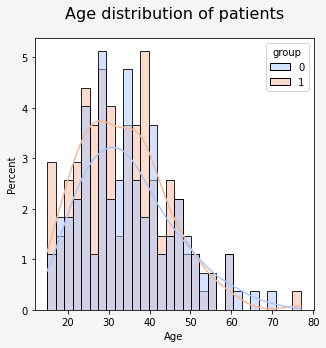

In [14]:
plt.figure(figsize=(5, 5),facecolor='#F6F5F4')
ax = sns.histplot(data=ms_df, x=ms_df['Age'], hue='group', stat='percent', common_norm=True, bins=30,kde=True, palette = 'coolwarm')
ax.set_title('Age distribution of patients', fontsize=16, y=1.05);

Text(0.5, 0, 'Schooling (years)')

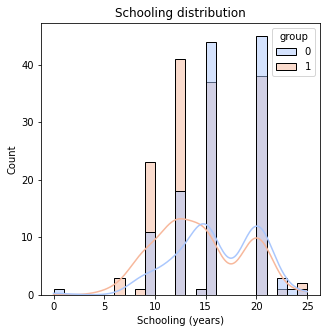

In [15]:
plt.figure(figsize = (5,5))
sns.histplot(data=ms_df, x='Schooling', hue='group',
             binwidth=1, kde=True, palette='coolwarm')
plt.title('Schooling distribution')
plt.xlabel('Schooling (years)')

#### Analyzing Categorical Data

In [ ]:
ms_df.groupby(['Periventricular_MRI','Infratentorial_MRI','Cortical_MRI', 'Spinal_Cord_MRI'])['group']\
.value_counts(normalize=True).mul(100).to_frame(name='Percent within group (%)').style.background_gradient(cmap=cmap)

### Analyzing dataset dirtribution

In [17]:
ms_df['group'].value_counts()

1    148
0    125
Name: group, dtype: int64

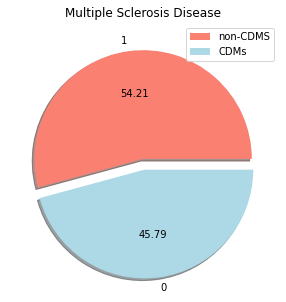

In [18]:
fig , ax= plt.subplots(figsize=(5,5))
group = ms_df.group.value_counts()
ax.pie(x = group.values ,
       labels = group.index ,
       shadow=True ,
       colors=["Salmon","lightblue"] ,
       explode = [0 , 0.1] ,
       autopct="%.2F" );
ax.set(title="Multiple Sclerosis Disease")
ax.legend(["non-CDMS","CDMs"]);

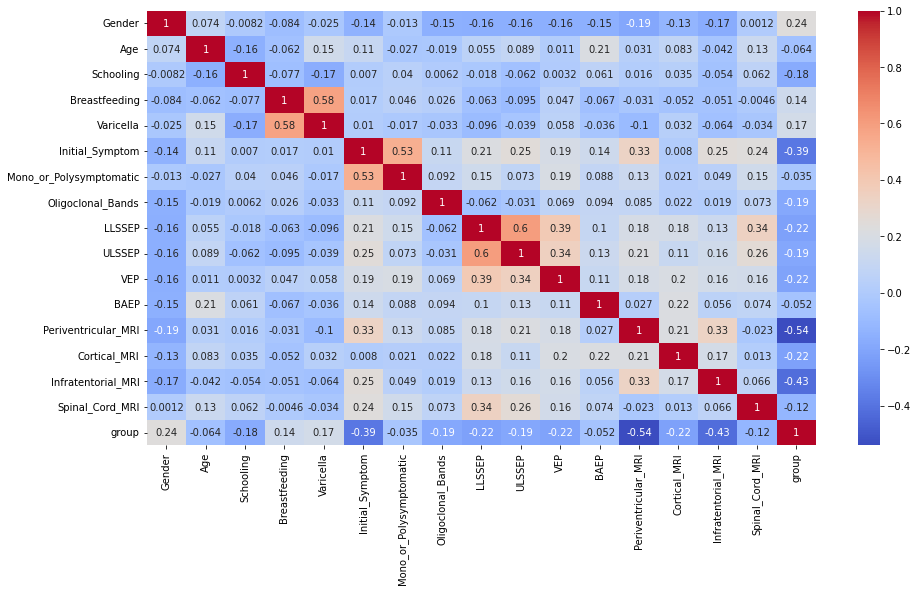

In [19]:
plt.figure(figsize =(15,8))
sns.heatmap(ms_df_imputed.corr(),annot =True,cmap = cmap)
plt.show()

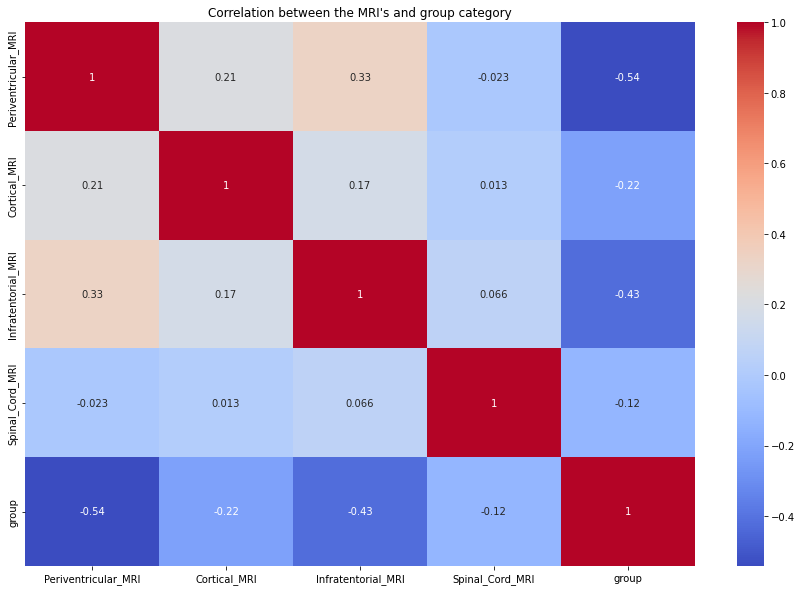

In [20]:
corr =ms_df.loc[:,['Periventricular_MRI','Cortical_MRI','Infratentorial_MRI','Spinal_Cord_MRI','group']].corr()
plt.figure(figsize=(15,10))
sns.heatmap(data = corr,cmap=cmap, annot = True)
plt.title('Correlation between the MRI\'s and group category');

In [21]:
ms_df_viz = ms_df_imputed.copy()

In [22]:
ms_df_viz['Gender'] = ms_df_viz['Gender'].map(gender)
ms_df_viz['Breastfeeding'] = ms_df_viz['Breastfeeding'].map(breastfeeding)
ms_df_viz['Varicella'] = ms_df_viz['Varicella'].map(varicella)
ms_df_viz['Mono_or_Polysymptomatic'] = ms_df_viz['Mono_or_Polysymptomatic'].map(mono_polysymptomatic)
ms_df_viz['Oligoclonal_Bands'] = ms_df_viz['Oligoclonal_Bands'].map(oligoclonal_bands)
ms_df_viz['LLSSEP'] = ms_df_viz['LLSSEP'].map(llssep)
ms_df_viz['ULSSEP'] = ms_df_viz['ULSSEP'].map(ulssep)
ms_df_viz['VEP'] = ms_df_viz['VEP'].map(vep)
ms_df_viz['BAEP'] = ms_df_viz['BAEP'].map(baep)
ms_df_viz['Periventricular_MRI'] = ms_df_viz['Periventricular_MRI'].map(per_mri)
ms_df_viz['Cortical_MRI'] = ms_df_viz['Cortical_MRI'].map(cor_mri)
ms_df_viz['Infratentorial_MRI'] = ms_df_viz['Infratentorial_MRI'].map(infra_mri)
ms_df_viz['Spinal_Cord_MRI'] = ms_df_viz['Spinal_Cord_MRI'].map(spinal_mri)
ms_df_viz['group'] = ms_df_viz['group'].map(groupmap)


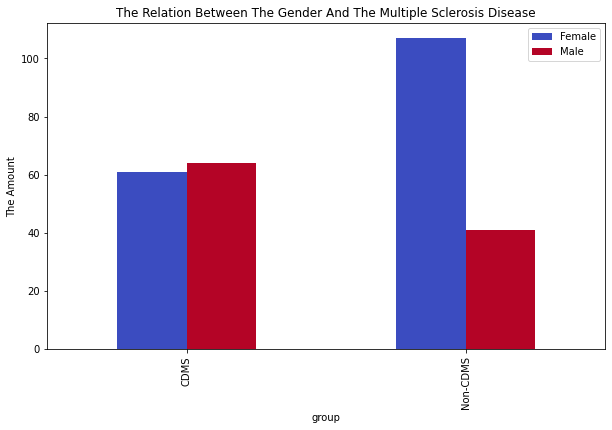

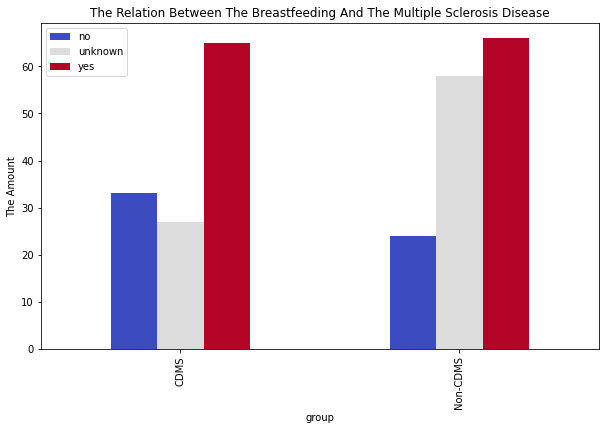

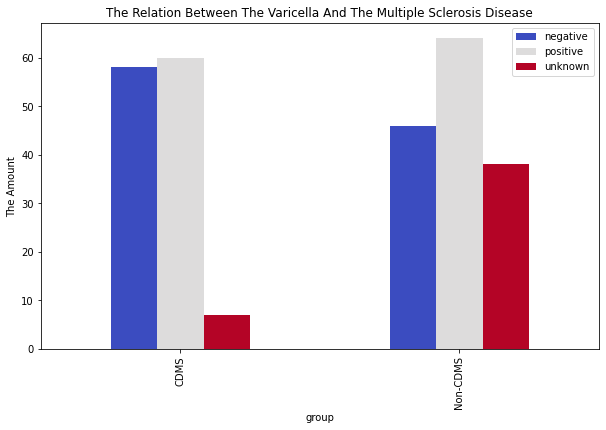

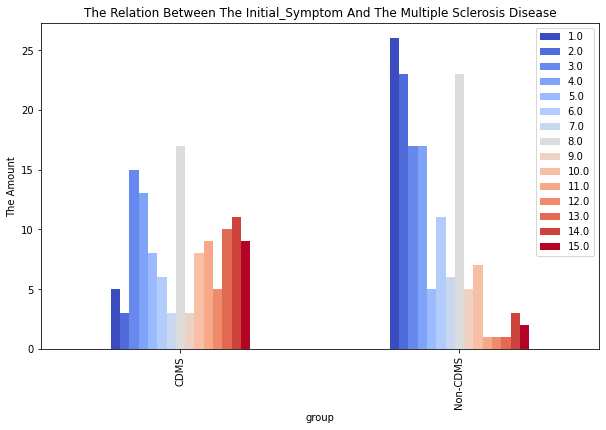

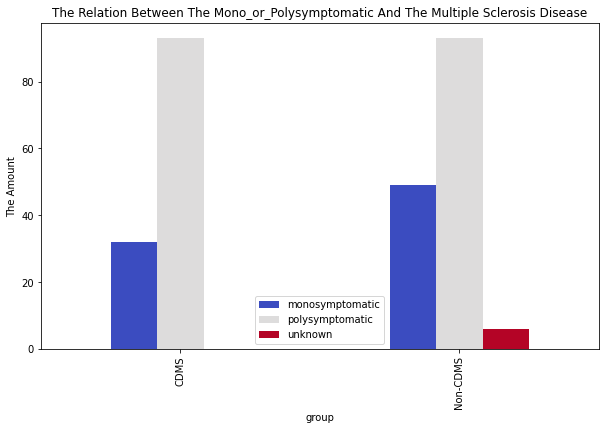

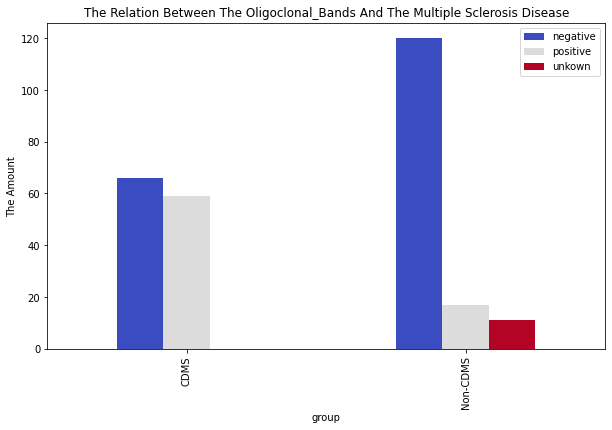

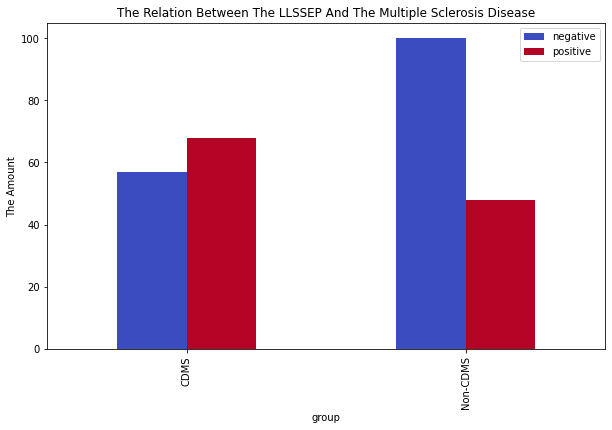

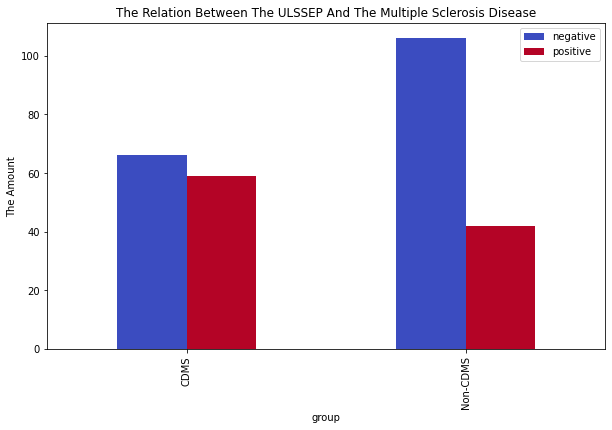

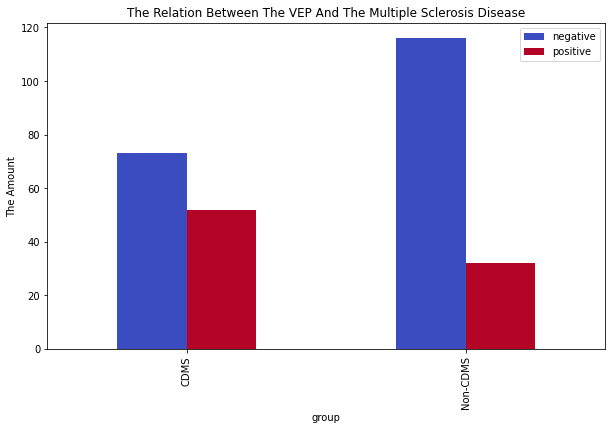

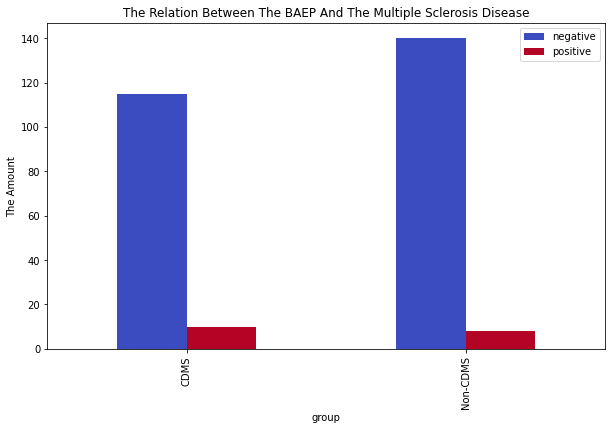

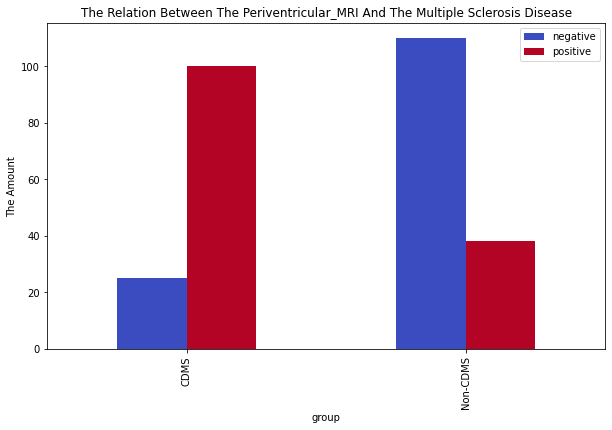

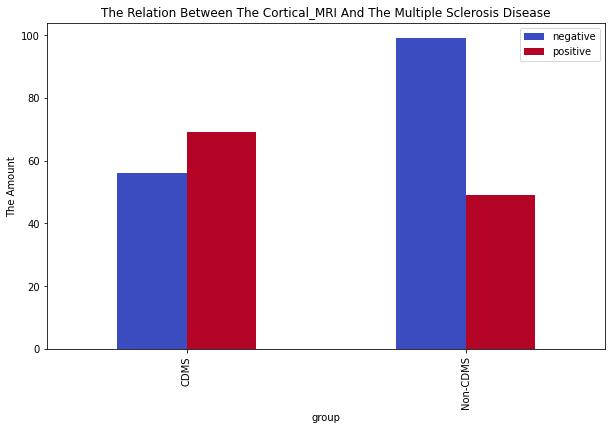

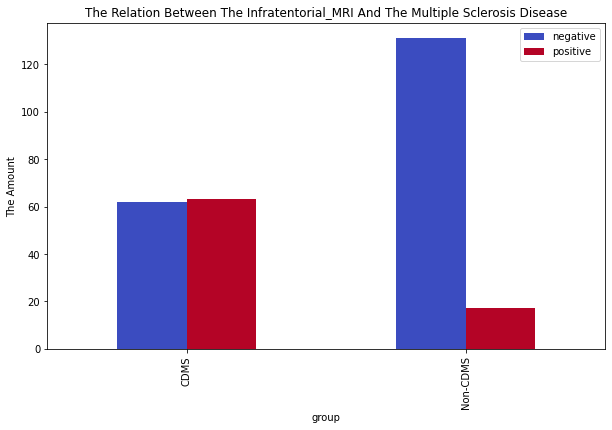

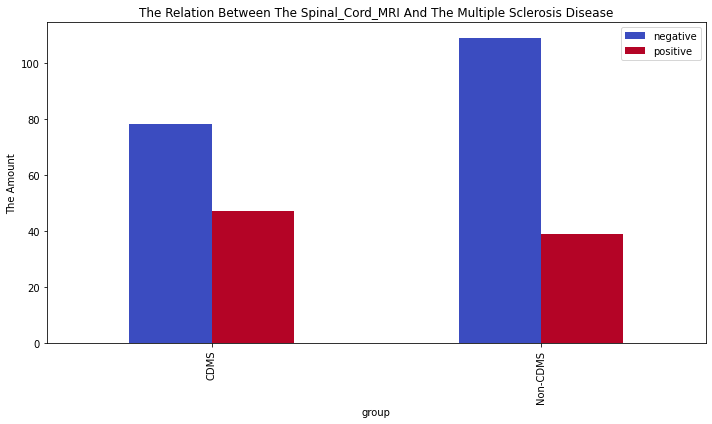

In [23]:
for i,var in enumerate(cat_cols):
    cat= pd.crosstab(ms_df_viz["group"], ms_df_viz[var])
    cat.plot(kind="bar" ,
            figsize=(10,6),
            title=f"The Relation Between The {var} And The Multiple Sclerosis Disease",
            cmap = cmap,
            );
    plt.ylabel("The Amount")
    plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
for i, feature in enumerate(cat_cols):
    count_plot(ms_df_viz, feature, 'Distribustion of the target variable - '+feature, hue=0)
    count_plot(ms_df_viz, feature, 'Distribustion of the target variable - '+feature, hue=1)


plt.tight_layout()
plt.show()

In [25]:
X = ms_df_imputed.drop("group",axis=1)
y = ms_df_imputed.group

In [26]:
print(f"Data features Shape = {X.shape}")
print(f"Label Shape = {y.shape}")

Data features Shape = (273, 16)
Label Shape = (273,)


In [27]:
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y,stratify=y,train_size=0.8,test_size=0.2,random_state=SEED)

In [28]:
X_train.shape, X_valtest.shape

((218, 16), (55, 16))

In [29]:
 y_train.shape, y_valtest.shape

((218,), (55,))

In [30]:
X_valid, X_test, y_valid, y_test = train_test_split(X_valtest, y_valtest,stratify=y_valtest,train_size=0.5,test_size=0.5,random_state=SEED)

In [31]:
print(f"Training Data Size: X_train = {X_train.shape} , y_train = {y_train.shape} ")
print(f"Validation Data Size: X_train = {X_valid.shape} , y_train = {y_valid.shape} ")
print(f"Testing Data Size: X_train = {X_test.shape} , y_train = {y_test.shape} ")

Training Data Size: X_train = (218, 16) , y_train = (218,) 
Validation Data Size: X_train = (27, 16) , y_train = (27,) 
Testing Data Size: X_train = (28, 16) , y_train = (28,) 


In [32]:
# Classifiers
classifiers = {
    "SVC" : SVC(random_state=SEED, probability=True),
    "RandomForest" : RandomForestClassifier(random_state=SEED),

}

# Grids for grid search

SVC_grid = {'C': [0.1,0.25, 0.5, 0.75, 1, 1.25, 1.5],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']}

RF_grid = {'n_estimators': list(range(5,100,5)),
        'max_depth': list(range(4,26,2))}


# Dictionary of all grids
grid = {
    "SVC" : SVC_grid,
    "RandomForest" : RF_grid,
}


In [33]:
i=0
clf_best_params=classifiers.copy()
valid_scores = pd.DataFrame({'Classifer': classifiers.keys(), 'Training accuracy': np.zeros(len(
    classifiers)), 'Testing accuracy': np.zeros(len(classifiers)), 'Training time': np.zeros(len(classifiers))})
for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None,scoring='f1')

    # Train and score
    clf.fit(X_train, y_train)
    valid_scores.iloc[i,1]=clf.score(X_train, y_train)
    valid_scores.iloc[i, 2] = clf.score(X_test, y_test)

    # Save trained model
    clf_best_params[key]=clf.best_params_
    
    # Print iteration and training time
    stop = time.time()
    valid_scores.iloc[i,3]=np.round((stop - start)/60, 2)
    
    print('Model:', key)
    print('Training time (mins):', valid_scores.iloc[i,3])
    print('')
    i+=1

Model: SVC
Training time (mins): 0.07

Model: RandomForest
Training time (mins): 0.4



In [34]:
valid_scores

,Classifer,Training accuracy,Testing accuracy,Training time
0,SVC,0.835443,0.875000,0.07
1,RandomForest,0.978355,0.827586,0.40


In [35]:
clf_best_params

{'SVC': {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'},
 'RandomForest': {'max_depth': 6, 'n_estimators': 70}}

In [36]:
# Classifiers
best_classifiers = {
     "RandomForest" : RandomForestClassifier(**clf_best_params["RandomForest"], random_state=SEED),
    "SVC" : SVC(**clf_best_params["SVC"], random_state=SEED,probability=True),
}

In [37]:

rf = RandomForestClassifier(**clf_best_params["RandomForest"], random_state=SEED)
svc = SVC(**clf_best_params["SVC"], random_state=SEED, probability=True)

In [38]:
cross_val_train_eval(rf, X_train, y_train, X_test, y_test)

Accuracy for each fold:
Fold 1: 0.8936170212765957
Fold 2: 0.8333333333333334
Fold 3: 0.7924528301886793
Fold 4: 0.851063829787234
Fold 5: 0.8
Average Training Accuracy: 0.8340934029171685
Accuracy: 0.8214285714285714


RF Sensitivity: 0.8
RF Specificity: 0.8461538461538461
RF Misclassification Rate: 0.17857142857142858


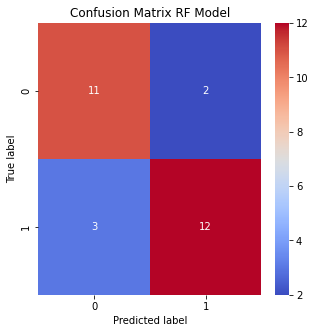

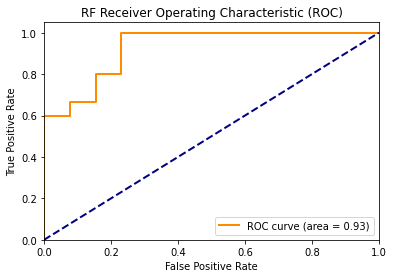

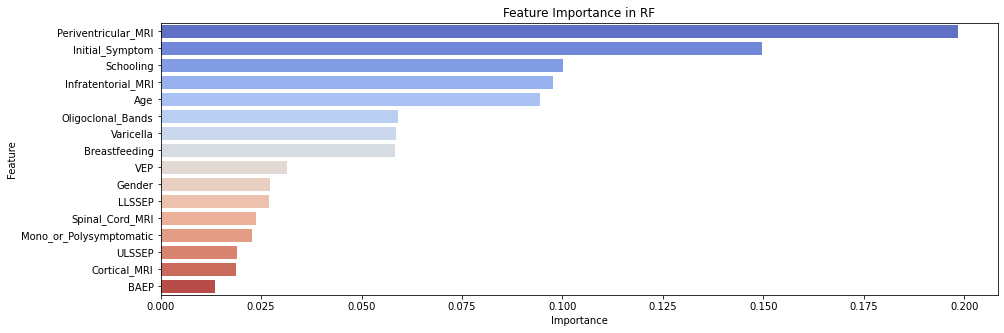

In [39]:
evaluate_model(rf,'RF', X_train, y_train, X_test, y_test)

In [40]:
cross_val_train_eval(svc, X_train, y_train, X_test, y_test)

Accuracy for each fold:
Fold 1: 0.8799999999999999
Fold 2: 0.7999999999999999
Fold 3: 0.8333333333333334
Fold 4: 0.8571428571428572
Fold 5: 0.8
Average Training Accuracy: 0.834095238095238
Accuracy: 0.8571428571428571


SVC Sensitivity: 0.9333333333333333
SVC Specificity: 0.7692307692307693
SVC Misclassification Rate: 0.14285714285714285


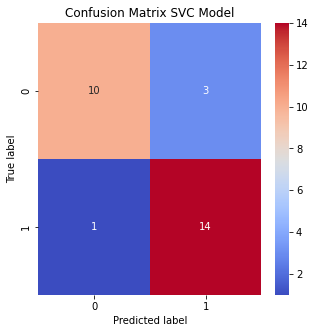

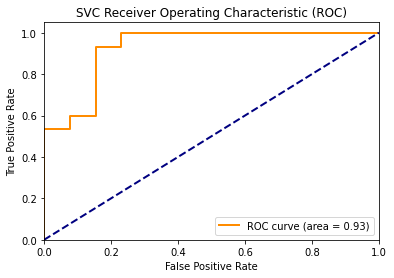

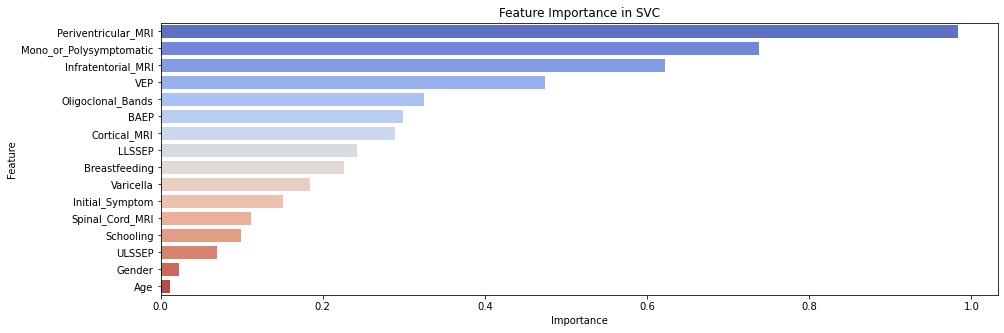

In [41]:
evaluate_model(svc,'SVC', X_train, y_train, X_test, y_test)

In [42]:
print(
    f"RF Metrics: {model_performance_classification_sklearn(rf,X_test,y_test)}")
print(
    f"SVC Metrics: {model_performance_classification_sklearn(svc,X_test,y_test)}")

RF Metrics:    Accuracy  Recall  Precision        F1
0  0.821429     0.8   0.857143  0.827586
SVC Metrics:    Accuracy    Recall  Precision     F1
0  0.857143  0.933333   0.823529  0.875
